In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

## Base vs Ensemble Learners

In [4]:
en_year_test = joblib.load("../split_year_models/ensemble/models_test_values.pkl")
en_income_test = joblib.load("../split_income_models/ensemble/models_test_values.pkl")

In [6]:
base_year_mean = joblib.load('../split_year_models/base_mean_metrics.pkl')
base_year_std = joblib.load('../split_year_models/base_std_metrics.pkl')
base_inc_mean = joblib.load('../split_income_models/base_mean_metrics.pkl')
base_inc_std = joblib.load('../split_income_models/base_std_metrics.pkl')

In [7]:
metrics = ['Relative Error', 'MAE', 'RMSE', 'MSE', 'R2']

In [ ]:
en_income_test = en_income_test.rename(index={'Random Forest':'Random Forest Ensemble'})

,MSE,MAE,R2,RMSE,Relative Error
Voting,7107.206787,25.005704,0.815028,84.304251,0.334763
Linear Regression,1689.050046,9.692333,0.956041,41.098054,0.192428
Random Forest Ensemble,2160.906806,8.683495,0.94376,46.485555,0.069516
SVM,3441.256655,25.158299,0.910438,58.662225,0.479697


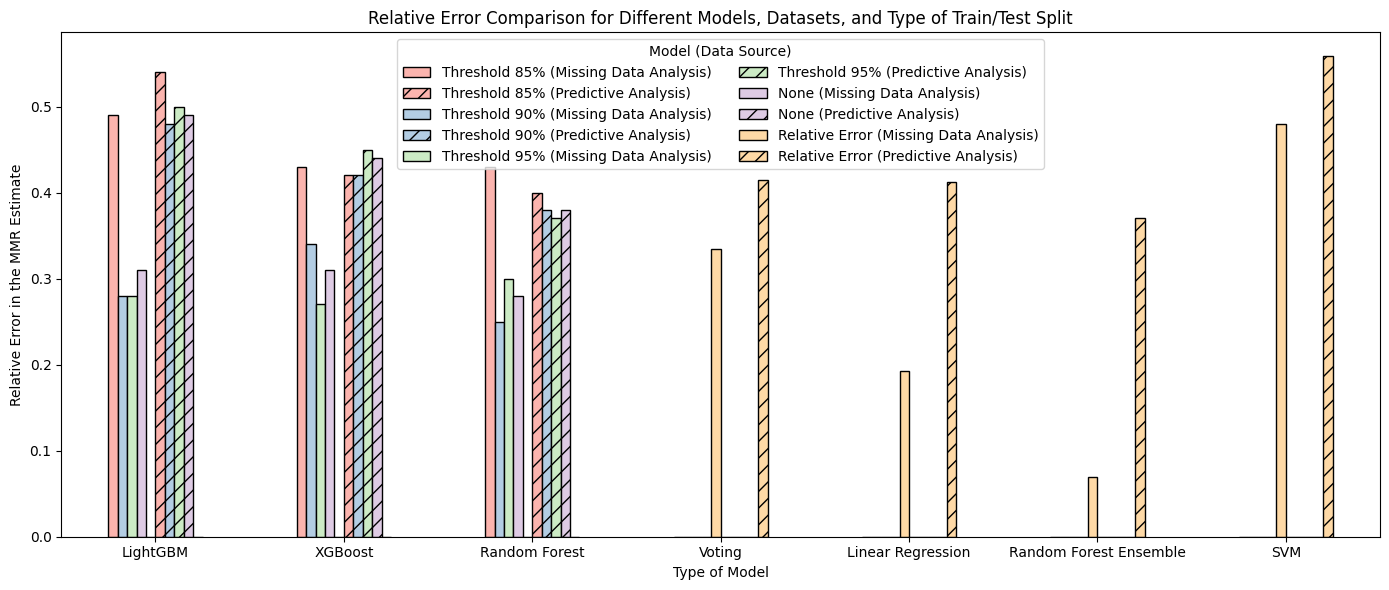

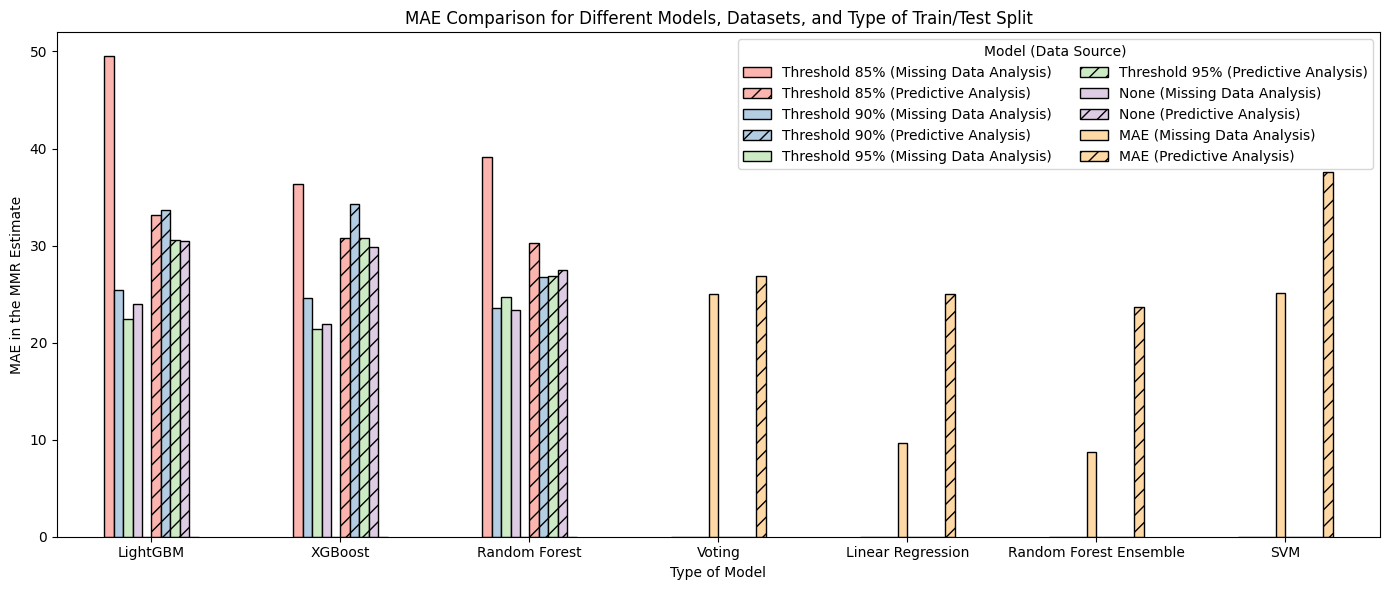

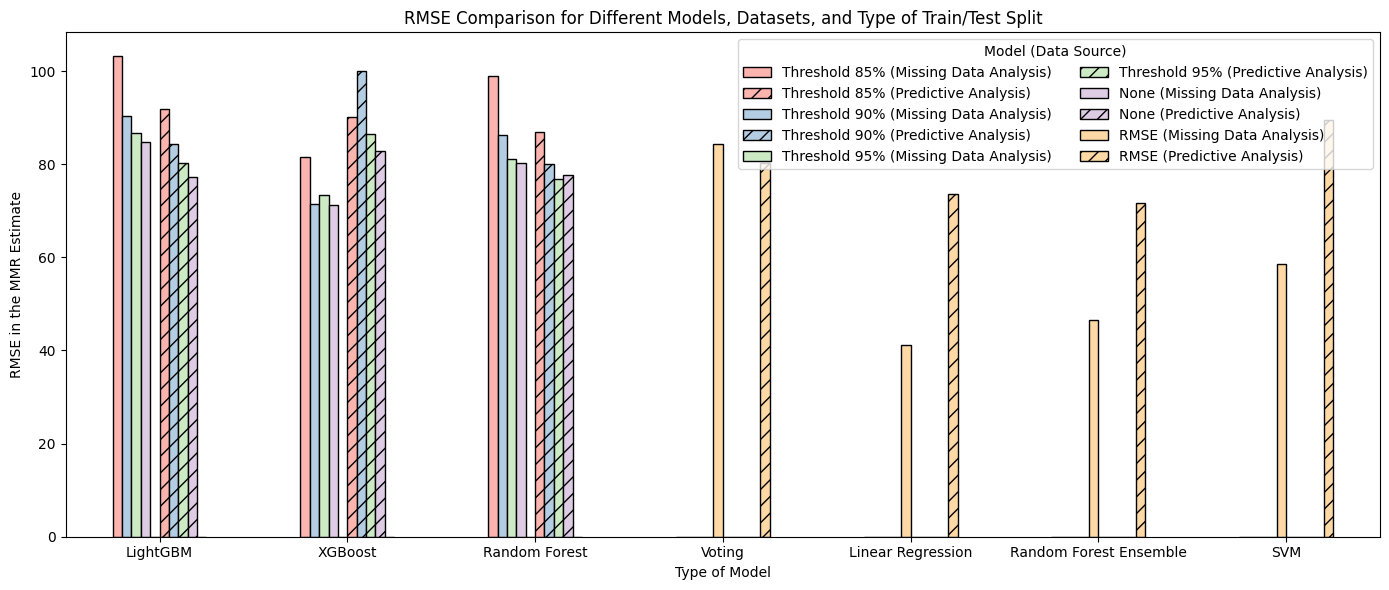

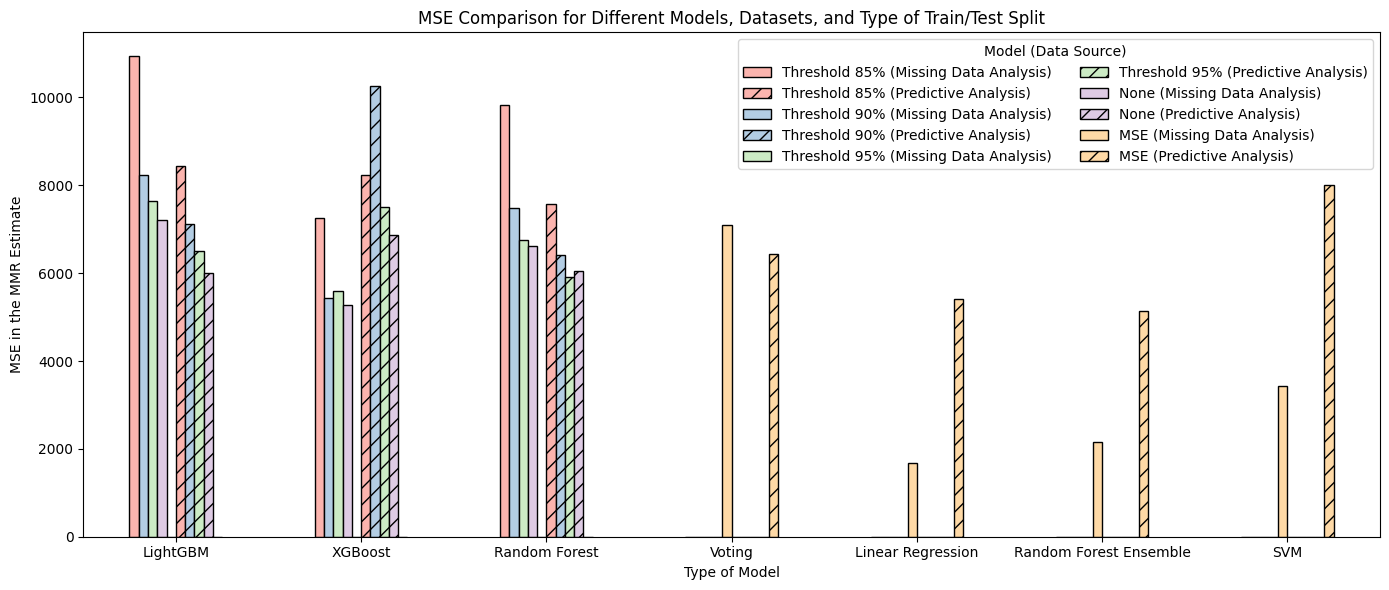

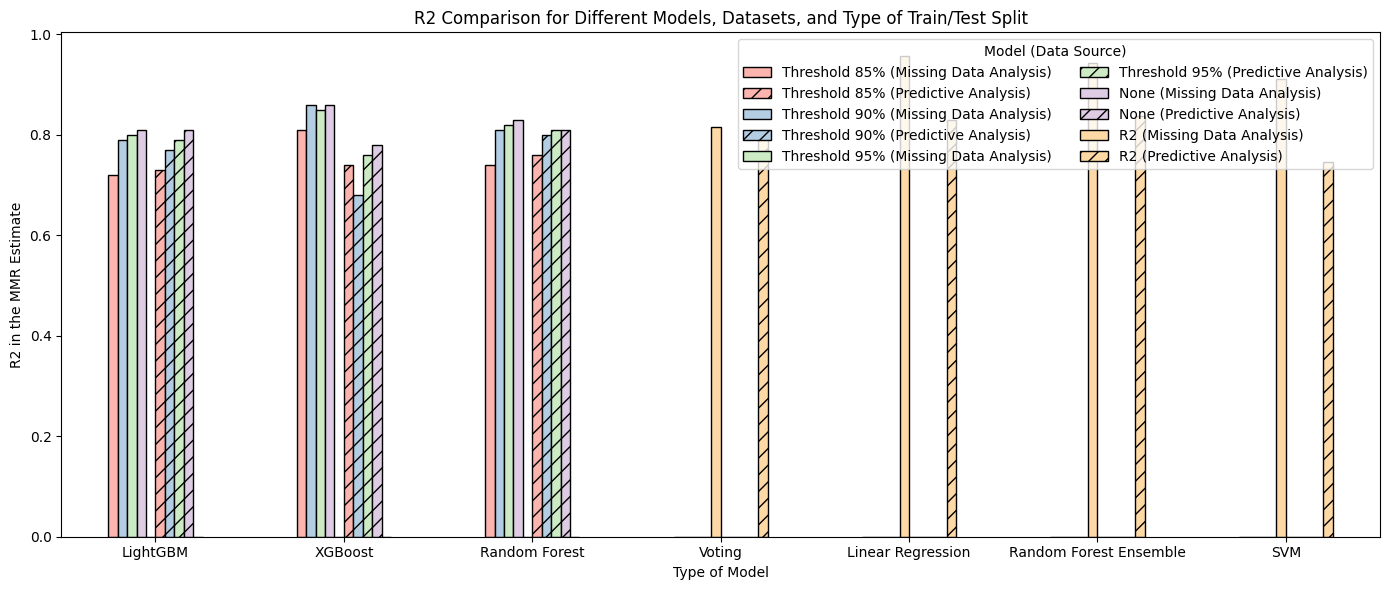

In [142]:
hatch_patterns = {'Predictive Analysis': '//', 'Missing Data': ''}
color_palette = plt.cm.Pastel1.colors  # Enough distinct colors for up to ~8 models

for metric in metrics:
    # Process year test data
    data_metric_year = en_year_test[metric]    
    data_mean_year = base_year_mean.xs(metric, axis=1, level='Metric')
    error_year = base_year_std.xs(metric, axis=1, level='Metric')

    # Combine year data for plotting
    combined_df_year = pd.concat([data_mean_year.transpose(), data_metric_year], axis=1)

    # Process income test data
    data_metric_income = en_income_test[metric]    
    data_mean_income = base_inc_mean.xs(metric, axis=1, level='Metric')
    error_income = base_inc_std.xs(metric, axis=1, level='Metric')

    # Combine income data for plotting
    combined_df_income = pd.concat([data_mean_income.transpose(), data_metric_income],axis=1)

    combined_df_year_name = combined_df_year.copy()
    combined_df_year_name.columns = pd.MultiIndex.from_product([combined_df_year.columns, ['Predictive Analysis']])

    combined_df_income_name = combined_df_income.copy()
    combined_df_income_name.columns = pd.MultiIndex.from_product([combined_df_income.columns, ['Missing Data Analysis']])

    combined_df = pd.concat([combined_df_income_name, combined_df_year_name], axis=1)

    ax = combined_df.plot.bar(rot=0, figsize=(14, 6), legend=False)

# Assign hatching and colors
    num_bars = len(combined_df.columns)
    for i, (col, bar_group) in enumerate(zip(combined_df.columns, ax.containers)):
        model_name, source = col
        color_idx = list(combined_df.columns.get_level_values(0)).index(model_name) % len(color_palette)
        hatch = hatch_patterns.get(source, '')

        for bar in bar_group:
            bar.set_hatch(hatch)
            bar.set_facecolor(color_palette[color_idx])
            bar.set_edgecolor('black')

    # === Custom Legend ===
    from matplotlib.patches import Patch
    models = combined_df.columns.get_level_values(0).unique()
    sources = combined_df.columns.get_level_values(1).unique()

    legend_patches = []
    for model in models:
        color = color_palette[list(models).index(model) % len(color_palette)]
        for source in sources:
            hatch = hatch_patterns.get(source, '')
            patch = Patch(facecolor=color, hatch=hatch, edgecolor='black',
                          label=f"{model} ({source})")
            legend_patches.append(patch)

    ax.legend(handles=legend_patches, title="Model (Data Source)", ncol=2)
    ax.set_title(f"{metric} Comparison for Different Models, Datasets, and Type of Train/Test Split")
    ax.set_ylabel(metric + ' in the MMR Estimate')
    ax.set_xlabel('Type of Model')
    plt.tight_layout()
    plt.show()

## Prediction Error

In [55]:
pred_error_income = joblib.load("../sensitivity_analysis/ensemble/income/prediction_error_inclevel.pkl")
pred_error_year = joblib.load("../sensitivity_analysis/ensemble/year/prediction_error_inclevel.pkl")

In [136]:
pred_error_income['Split'] = 'Missing Data Analysis'
pred_error_year['Split'] = 'Predictive Analysis'

In [138]:
pred_error = pd.concat([pred_error_income, pred_error_year])

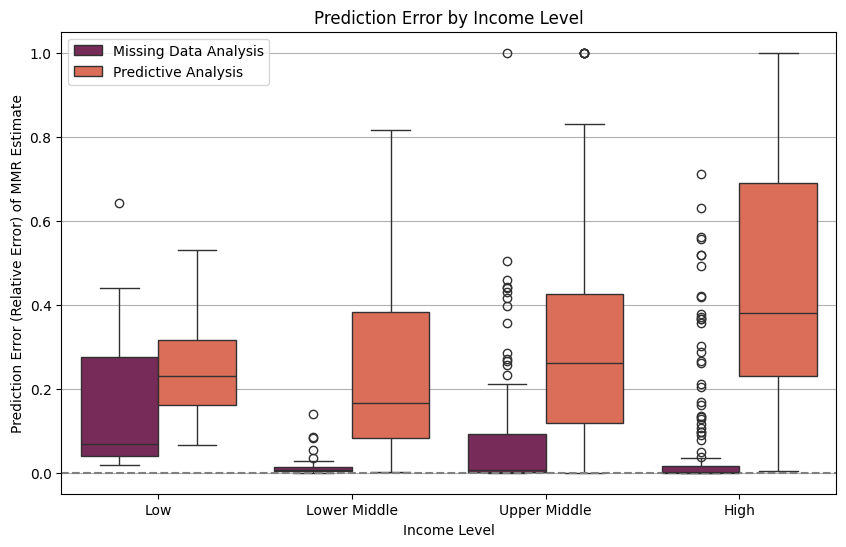

In [140]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Income Level', y='Prediction Error', data=pred_error, hue='Split', palette='rocket')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error by Income Level")
plt.ylabel("Prediction Error (Relative Error) of MMR Estimate")
plt.xlabel("Income Level")
plt.grid(axis='y')
plt.legend()
plt.show()

## Comparison to the Literature

In [103]:
year_comp = joblib.load("../split_year_models/ensemble/all_comp.pkl")
inc_comp = joblib.load("../split_income_models/ensemble/all_comp.pkl")

In [104]:
year_comp = year_comp.rename(columns={'ensemble_mmr':'ensemble_year'})
inc_comp = inc_comp.rename(columns={'ensemble_mmr':'ensemble_inc'})

In [118]:
lit_comp = pd.merge(year_comp, inc_comp, on=['year', 'name', 'national_estimate', 'mortality', 'mortality_lb', 'mortality_ub', 'FactValueNumeric', 'FactValueNumericLow', 'FactValueNumericHigh', 'val', 'upper', 'lower'], how='outer')

In [119]:
lit_comp[lit_comp['name'] == 'New Zealand']

,year,name,ensemble_year,national_estimate,mortality,mortality_lb,mortality_ub,percent_diff_x,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh,percent_diff_mmeig_x,val,upper,lower,percent_diff_gbd_x,ensemble_inc,percent_diff_y,percent_diff_mmeig_y,percent_diff_gbd_y
67,2016.0,New Zealand,9.882905,10.0,49.3,0.0,177.3,-79.953540,7.67,5.92,9.23,28.851431,8.160880,9.782115,6.881122,21.100973,4.376812,-91.122086,-42.935964,-46.368385
141,2015.0,New Zealand,11.107788,3.0,50.4,0.0,175.5,-77.960738,8.05,6.44,9.56,37.984944,9.980775,11.835518,8.537373,11.291837,6.217391,-87.663906,-22.765325,-37.706328
175,2014.0,New Zealand,NaN,13.0,49.3,0.0,170.6,NaN,7.45,6.09,8.79,NaN,8.904858,10.596056,7.568801,NaN,6.613527,-86.585139,-11.227831,-25.731249
179,1990.0,New Zealand,NaN,7.0,164.4,0.0,476.0,NaN,17.54,15.11,20.76,NaN,10.675652,12.545368,9.108569,NaN,8.782609,-94.657781,-49.928115,-17.732345
189,2004.0,New Zealand,NaN,7.0,63.3,0.0,176.6,NaN,10.65,9.09,12.14,NaN,9.037978,10.743168,7.631674,NaN,7.922705,-87.483878,-25.608401,-12.339848
202,2008.0,New Zealand,NaN,14.0,56.5,0.0,187.8,NaN,9.82,8.54,11.25,NaN,13.248820,15.658596,11.211474,NaN,9.000000,-84.070796,-8.350305,-32.069421
206,2003.0,New Zealand,NaN,7.0,65.3,0.0,194.5,NaN,10.85,9.20,12.40,NaN,9.896058,11.686029,8.325404,NaN,6.106280,-90.648882,-43.720920,-38.295835
209,2011.0,New Zealand,NaN,8.0,54.7,0.0,185.5,NaN,10.07,8.62,11.56,NaN,11.678119,13.659485,9.781935,NaN,8.676329,-84.138339,-13.839836,-25.704401
219,1999.0,New Zealand,NaN,7.0,75.4,0.0,212.8,NaN,11.79,9.77,13.57,NaN,9.754901,11.497033,8.063481,NaN,6.323671,-91.613168,-46.364109,-35.174415
227,2000.0,New Zealand,NaN,9.0,71.3,0.0,206.1,NaN,10.68,8.93,12.28,NaN,10.315189,12.071114,8.535035,NaN,5.661836,-92.059136,-46.986557,-45.111663


In [120]:
lit_comp = lit_comp.sort_values('year')

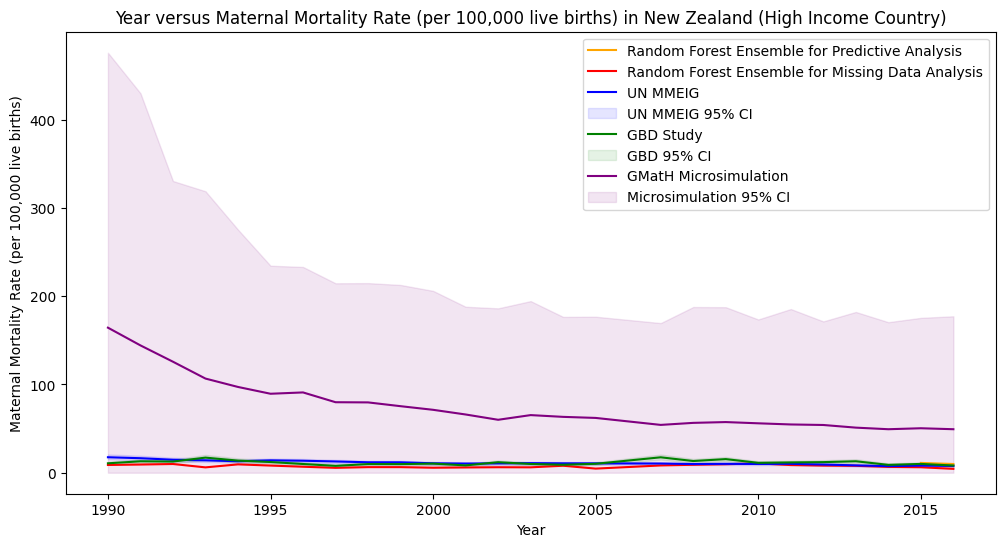

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['ensemble_year'], label='Random Forest Ensemble for Predictive Analysis', c='orange')
plt.plot(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['ensemble_inc'], label='Random Forest Ensemble for Missing Data Analysis', c='red')
plt.plot(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['FactValueNumeric'], label='UN MMEIG', c='blue')
plt.fill_between(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['FactValueNumericLow'],  lit_comp[lit_comp['name'] == 'New Zealand']['FactValueNumericHigh'], alpha=0.1, color='blue', label='UN MMEIG 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['val'], label='GBD Study', c='green')
plt.fill_between(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['lower'],  lit_comp[lit_comp['name'] == 'New Zealand']['upper'], alpha=0.1, color='green', label='GBD 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['mortality'], label='GMatH Microsimulation', c='purple')
plt.fill_between(lit_comp[lit_comp['name'] == 'New Zealand']['year'], lit_comp[lit_comp['name'] == 'New Zealand']['mortality_lb'],  lit_comp[lit_comp['name'] == 'New Zealand']['mortality_ub'], alpha=0.1, color='purple', label='Microsimulation 95% CI')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Maternal Mortality Rate (per 100,000 live births)')
plt.title('Year versus Maternal Mortality Rate (per 100,000 live births) in New Zealand (High Income Country)')
plt.show()

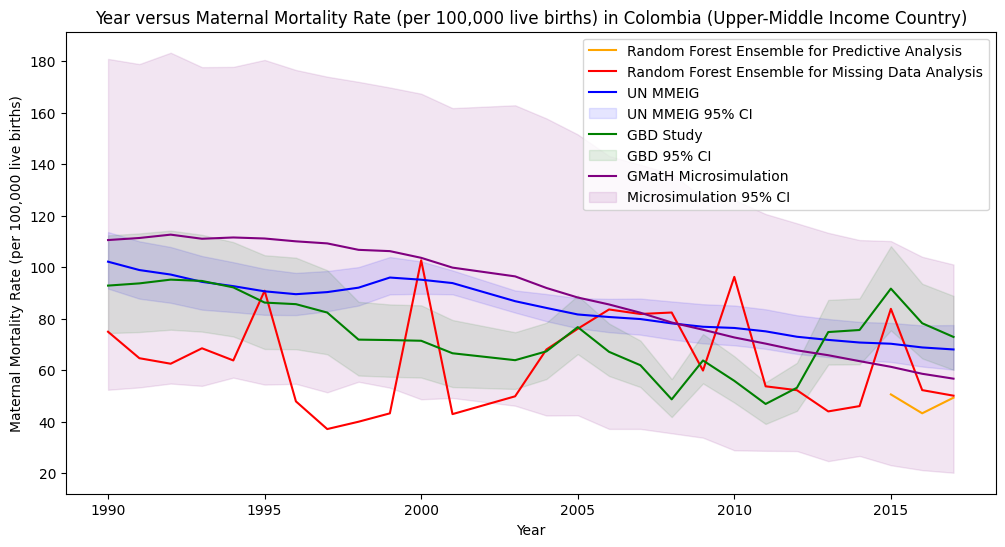

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['ensemble_year'], label='Random Forest Ensemble for Predictive Analysis', c='orange')
plt.plot(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['ensemble_inc'], label='Random Forest Ensemble for Missing Data Analysis', c='red')
plt.plot(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['FactValueNumeric'], label='UN MMEIG', c='blue')
plt.fill_between(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['FactValueNumericLow'],  lit_comp[lit_comp['name'] == 'Colombia']['FactValueNumericHigh'], alpha=0.1, color='blue', label='UN MMEIG 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['val'], label='GBD Study', c='green')
plt.fill_between(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['lower'],  lit_comp[lit_comp['name'] == 'Colombia']['upper'], alpha=0.1, color='green', label='GBD 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['mortality'], label='GMatH Microsimulation', c='purple')
plt.fill_between(lit_comp[lit_comp['name'] == 'Colombia']['year'], lit_comp[lit_comp['name'] == 'Colombia']['mortality_lb'],  lit_comp[lit_comp['name'] == 'Colombia']['mortality_ub'], alpha=0.1, color='purple', label='Microsimulation 95% CI')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Maternal Mortality Rate (per 100,000 live births)')
plt.title('Year versus Maternal Mortality Rate (per 100,000 live births) in Colombia (Upper-Middle Income Country)')
plt.show()

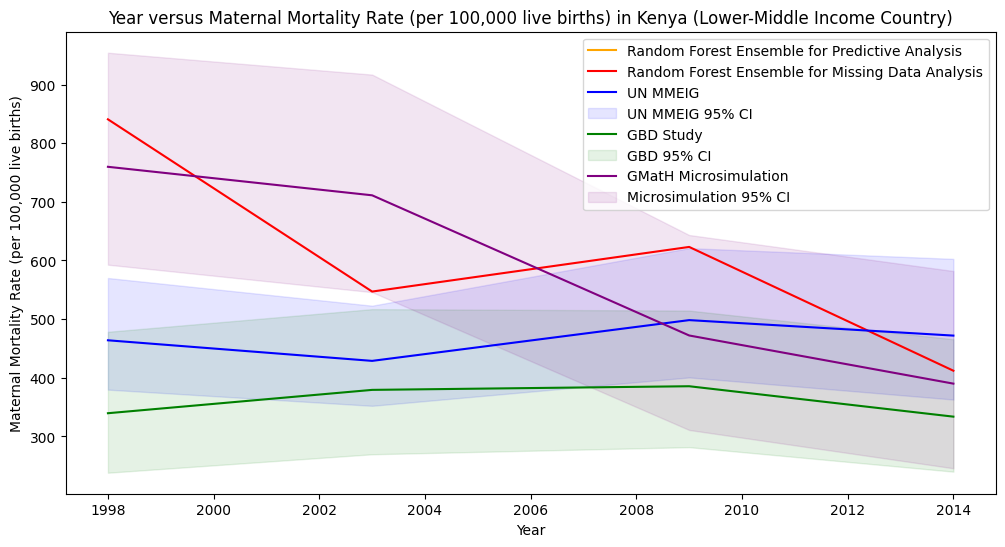

In [134]:
plt.figure(figsize=(12, 6))
plt.plot(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['ensemble_year'], label='Random Forest Ensemble for Predictive Analysis', c='orange')
plt.plot(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['ensemble_inc'], label='Random Forest Ensemble for Missing Data Analysis', c='red')
plt.plot(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['FactValueNumeric'], label='UN MMEIG', c='blue')
plt.fill_between(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['FactValueNumericLow'],  lit_comp[lit_comp['name'] == 'Kenya']['FactValueNumericHigh'], alpha=0.1, color='blue', label='UN MMEIG 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['val'], label='GBD Study', c='green')
plt.fill_between(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['lower'],  lit_comp[lit_comp['name'] == 'Kenya']['upper'], alpha=0.1, color='green', label='GBD 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['mortality'], label='GMatH Microsimulation', c='purple')
plt.fill_between(lit_comp[lit_comp['name'] == 'Kenya']['year'], lit_comp[lit_comp['name'] == 'Kenya']['mortality_lb'],  lit_comp[lit_comp['name'] == 'Kenya']['mortality_ub'], alpha=0.1, color='purple', label='Microsimulation 95% CI')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Maternal Mortality Rate (per 100,000 live births)')
plt.title('Year versus Maternal Mortality Rate (per 100,000 live births) in Kenya (Lower-Middle Income Country)')
plt.show()

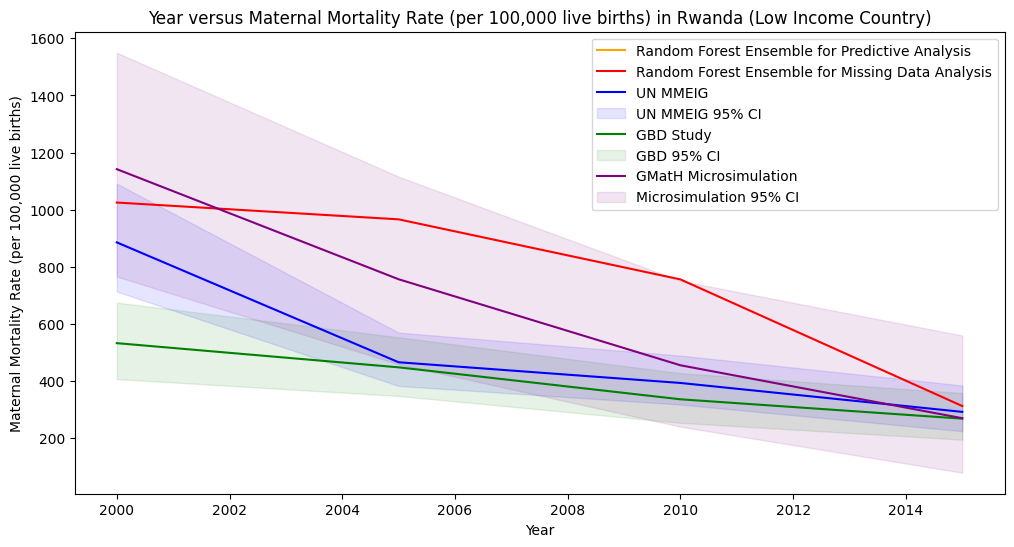

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['ensemble_year'], label='Random Forest Ensemble for Predictive Analysis', c='orange')
plt.plot(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['ensemble_inc'], label='Random Forest Ensemble for Missing Data Analysis', c='red')
plt.plot(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['FactValueNumeric'], label='UN MMEIG', c='blue')
plt.fill_between(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['FactValueNumericLow'],  lit_comp[lit_comp['name'] == 'Rwanda']['FactValueNumericHigh'], alpha=0.1, color='blue', label='UN MMEIG 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['val'], label='GBD Study', c='green')
plt.fill_between(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['lower'],  lit_comp[lit_comp['name'] == 'Rwanda']['upper'], alpha=0.1, color='green', label='GBD 95% CI')
plt.plot(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['mortality'], label='GMatH Microsimulation', c='purple')
plt.fill_between(lit_comp[lit_comp['name'] == 'Rwanda']['year'], lit_comp[lit_comp['name'] == 'Rwanda']['mortality_lb'],  lit_comp[lit_comp['name'] == 'Rwanda']['mortality_ub'], alpha=0.1, color='purple', label='Microsimulation 95% CI')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Maternal Mortality Rate (per 100,000 live births)')
plt.title('Year versus Maternal Mortality Rate (per 100,000 live births) in Rwanda (Low Income Country)')
plt.show()